In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma
from scipy.stats import norm
import scipy.stats as stats

Script écrit par Martin Vérot, PRAG en chimie à l'ENS de Lyon, grâce à un script original de Jean Lamerenx
https://jlamerenx.fr/python/
Un cours plus complete est disponible ici : http://agregationchimie.free.fr/cours.php#incertitudes 


Il est possible de changer le nombre de tirages simulés, les paramètres d'entrée et la fonction.

Pour définir un paramètre d'entrée, il faut lui donner un nom, une forme de distribution, une valeur la plus probable et une étendue. Les types de distribution possibles sont :
    - `triangulaire`, dans ce cas, l'étendue est la demi-largeur de la distribution 
    - `rectangulaire`, dans ce cas, l'étendue est la demi-largeur de la distribution 
    - `gaussienne`, dans ce cas, l'étendue est l'écart-type de la distribution
    - pour rajouter de nouvelles formes de distribution, il faut modifier la fonction "tirage" en consequence

Ensuite, il faut définir la fonction qui calcule la variable de sortie en fonction de l'ensemble des variables d'entrée : 
$$z=f(x_1,...x_n)$$
La fonction est définie à l'avant dernière ligne de la fonction "grandeurExtraite" où il faut remplacer chaque variable $x_i$ par `valeurs('x_i',params,value)`


Par exemple, pour calculer $z=B\times\exp(-k\times E)$ avec $B$, $k$, et $E$ les paramètres d'entrée, il faudrait changer pour avoir quelque chose similaire à :
```
Adaptation de la définition des paramètres d'entrée à notre cas :

####################### 
params = [
    {'name':'B','distribution':'rectangulaire','valeur':0.1,'etendue':0.01},
    {'name':'k','distribution':'rectangulaire','valeur':10.0,'etendue':1.0},
    {'name':'E','distribution':'rectangulaire','valeur':10.0,'etendue':0.1}
]
#######################
Changement de la fonction à calculer pour le paramètre de sortie :
#######################
    OutputValue = valeurs('B',params,value)*np.exp(-valeurs('k',params,value)*valeurs('E',params,value))
#######################
```

# Nombre de tirages simulés

In [2]:
N=100000  

# Paramètres utilisés et leur distribution

In [3]:
params = [
        {'name':'Cb','distribution':'rectangulaire','valeur':0.1,'etendue':0.01},
        {'name':'Vb','distribution':'rectangulaire','valeur':10.0,'etendue':1.0},
        {'name':'Va','distribution':'rectangulaire','valeur':10.0,'etendue':0.1}
        ]

# Titre du graphique

In [4]:
bigtitle =  'Simulation de {} tirages'.format(N)
abscisse = 'Ca en mol/L'

# Indiquer la fonction étudiée pour ce cas

In [5]:
####
#Fonction à changer en fonction du cas étudié !!!! 
####
def grandeurExtraite(params,N):
    """ la grandeur finale à calculer, par exemple Ca=Cb*Vb/Va 
    les variables d'entrées seront différentes grandeurs données dans params. 
    Ainsi, Cb = params[0],Vb=params[1],Va=params[2]
    """
    #on calcule les N tirages de chacun des paramètres
    value = np.zeros((len(params),N))
    for i in range(len(params)):
        value[i]=np.reshape(tirage(params[i],N),(1,N))
    ##################
    ## !!!!!! CHANGER LA FONCTION POUR L'ADAPTER AU CAS ETUDIÉ !!!!!!!!
    ##################
    OutputValue = valeurs('Cb',params,value)*valeurs('Vb',params,value)/valeurs('Va',params,value)
    return (OutputValue,value)

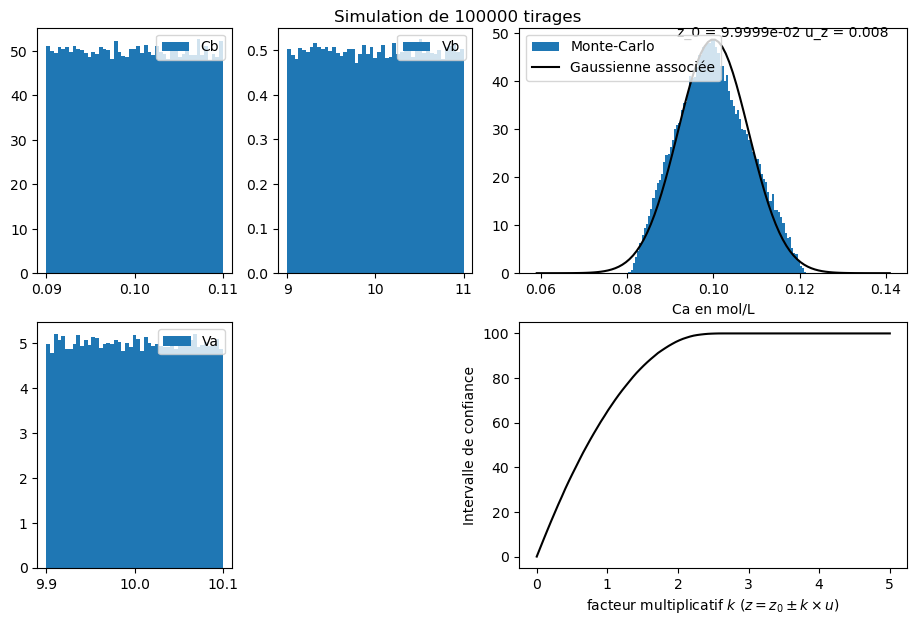

In [6]:
############################################
##Il n'y a plus rien à changer au-delà de cette ligne
############################################

def tirage(param,N):
    """
    fonction pour effectuer N tirages parmi les distributions usuelles
    param doit contenir différentes informations :
    - en premier argument le nom de la variable
    - en deuxième argument, la forme de la distribution : 'triangulaire','rectangulaire','gaussienne'
    - en troisième argument, la valeur moyenne de la distribution
    - en quatrième argument le paramètre servant à décrire la largeur de la distribution :
        - pour les distributions triangulaires et rectangulaire : la DEMI-largeur de la distribution
        - pour la distribution gaussienne, l'écart-type de la distribution
    """
    if param['distribution']=='rectangulaire':
        return np.random.uniform(param['valeur']-param['etendue'],param['valeur']+param['etendue'],N) 
    if param['distribution']=='triangulaire':
        return np.random.triangular(param['valeur']-param['etendue'],param['valeur'],param['valeur']+param['etendue'],N) 
    if param['distribution']=='gaussienne':
        return np.random.normal(param['valeur'],param['etendue'],N) 

def valeurs(paramName,params,value):
    """
    trouver les valeurs correspondant à paramName dans value à partir du tableau params
    cela permet de rendre plus simple l'expression du résultat à trouver à partir de noms de paramètres plutôt que d'indice
    """
    ####
    # Voir comment trouver l'indice d'un objet ayant une propriété avec un nom précis
    ####
    return value[params.index(next((sub for sub in params if sub['name'] == paramName), None))]

def PropOutput(result):
    """
    Calcul de la moyenne de la distribution ainsi que de l'écart-type réduit 
    """
    return (np.average(result),np.std(result,ddof=1))                                                           

def IntervalleConfiance(x,data,moy):
    """
    Estimer l'intervalle de confiance associé à l'intervalle centré sur la valeur moyenne
    """
    count = ((moy-x < data) & (data < moy+x)).sum()/data.size*100.
    return count


#valeurs des N tirages pour le résultat final
Output,values = grandeurExtraite(params,N)
Output = np.sort(Output)
#valeur moyenne et incertitude type de la grandeur finale
moy,u = PropOutput(Output)



#abscisse
x = np.linspace(moy-5*u,moy+5*u,100)
Gauss = stats.norm.pdf(x, moy, u)
nbParams = len(params)
SquareGridSize=int(np.ceil(np.sqrt(nbParams)))
widths = np.ones(SquareGridSize+1)
widths[-1]=SquareGridSize

fig = plt.figure(figsize=(10,6))
gs = fig.add_gridspec(SquareGridSize,SquareGridSize+1,  width_ratios=tuple(widths), height_ratios=tuple(np.ones(SquareGridSize,dtype='uint')), left=0.08, right=0.95, bottom=0.05, top=0.95, wspace=0.18, hspace=0.2)

#Plot final avec histogramme de la valeur en sortie
ax1 = fig.add_subplot(gs[:int(np.ceil(SquareGridSize/2)),SquareGridSize])
ax1.hist(Output, bins='auto',density = True, label = "Monte-Carlo")
ax1.plot(x, Gauss, 'k-', label = "Gaussienne associée")
fig.suptitle(bigtitle)
ax1.set_xlabel(abscisse)
ax1.text(0.95, 0.95, 'z_0 = {:2.4e} u_z = {:.3f}'.format(moy,u), horizontalalignment='right',
     verticalalignment='bottom', transform=ax1.transAxes)
ax1.legend(loc='upper left')

#Tracé de l'intervalle de confiance lié à la largeur de l'intervalle
ax2 = fig.add_subplot(gs[int(np.ceil(SquareGridSize/2)):,SquareGridSize])
Intervalles = []
x2 = np.linspace(0,5*u,100)
for value in x2.tolist():
    Intervalles.append(IntervalleConfiance(value, Output,moy))
ax2.plot(x2/u, Intervalles, 'k-', label = "")
ax2.set_xlabel('facteur multiplicatif $k$ ($z=z_0\pm k \\times u $)')
ax2.set_ylabel('Intervalle de confiance')


#Plot de chacune des valeurs d'entrée
for i in range(nbParams):
    quo = i // SquareGridSize 
    ligne= quo
    colonne = i - quo*SquareGridSize
    #print('i {} l {} c {} '.format(i,ligne,colonne))
    ax = fig.add_subplot(gs[ligne,colonne])
    ax.hist(values[i],bins='auto',density = True, label = params[i]['name'])
    ax.legend(loc='upper right')

plt.savefig("MC.svg")
plt.show()